# Comparison of the bot scores calculated by Botometer with the coordination level of the users

This notebook comes with a problem. The coordination detection pipeline relies on Tweepy v4.8.0 while Botometer needs a Tweepy version smaller than 4.0. Thus, the both Tweepy versions are incompatible. Therefore, one has to execute the coordiantion pipeline in another notebook, where the used Python kernel has the respective package versions installed. The results must be stored to a parquet files and loaded in this notebook, where another Python kernel is used, that has the right packages for Botometer.

### Handle imports

In [7]:
%load_ext autoreload
%autoreload 2
import sys # added!
sys.path.append("..") # added!
from coordination_detection import pipeline

from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load API secrets for Twitter and RapidAPI

In [8]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### Calculate similarities based on Twitter data

In [ ]:
time = datetime.strptime("2022-02-21 13:01:16", "%Y-%m-%d %H:%M:%S")
similarity = pipeline.calculate_coordination_pipeline_twitter_data("8273444c-abdd-4410-829a-970846ebd00e", 14, time)
similarity.to_parquet("./parquet_saves/save.snappy", compression="snappy")

### Change the kernel to a kernel that has botometer installed and continue the execution from this point

In [ ]:
from datetime import datetime
import os

import pandas as pd
import numpy as np
from pymongo import MongoClient
from tqdm import tqdm
import matplotlib.pyplot as plt
import botometer

In [2]:
similarity = pd.read_parquet("./parquet_saves/swift twitter data.snappy")

### Extract coordiantion levels for the users

In [21]:
similarity = similarity.sort_values("Weight", ascending=False).reset_index(drop=True)

users = pd.DataFrame(columns=["User", "Weight"])
for _, row in tqdm(similarity.iterrows(), total=len(similarity)):
    if row["User1"] not in users["User"].values:
        temp = pd.DataFrame([[row["User1"], row["Weight"]]], columns=['User', 'Weight'])
        users = pd.concat([users, temp], ignore_index=True)
    if row["User2"] not in users["User"].values:
        temp = pd.DataFrame([[row["User2"], row["Weight"]]], columns=['User', 'Weight'])
        users = pd.concat([users, temp], ignore_index=True)

100%|██████████| 2864601/2864601 [09:09<00:00, 5212.02it/s]


### Transform the user screen names to Twitter ids

In [26]:
source_uuid = "8273444c-abdd-4410-829a-970846ebd00e"
connection = MongoClient(f"mongodb://localhost:27017/")
db = connection.textclustDB
ids = np.array((), dtype="int")
for i, row in users.iterrows():
    id = db[f"texts_{source_uuid}"].find_one({"specific.user.screen_name": row["User"]}, projection={"_id": 0, "id": "$specific.user.id"})
    ids = np.append(ids, (id['id']))
users["id"] = ids

### Request Botometer scores over the API

In [28]:
def get_bot_score(user):
  rapidapi_key = os.getenv("RAPIDAPI_KEY")
  twitter_app_auth = {
      'consumer_key': os.getenv("API_KEY"),
      'consumer_secret': os.getenv("API_SECRET"),
      'access_token': os.getenv("ACCESS_TOKEN"),
      'access_token_secret': os.getenv("ACCESS_SECRET"),
    }
  bom = botometer.Botometer(wait_on_ratelimit=True,
                            rapidapi_key=rapidapi_key,
                            **twitter_app_auth)
  result = bom.check_account(user["id"])
  return{user["User"]: result["raw_scores"]["english"]["overall"]}

In [60]:
botscores = []
for _, user in tqdm(users.iterrows(), total=len(users)):
    try: 
        botscores.append(get_bot_score(user))
    except:
        continue
botscores.to_parquet("./parquet_saves/swift_botscores.snappy", compression="snappy")

In [ ]:
botscores = pd.read_parquet("./parquet_saves/swift_botscores.snappy")

### Create a list for the weights of the users and the mean botscores of the users for that coordination level

In [66]:
coordinations = users["Weight"].drop_duplicates().values
mean_botscores = []
for coordination in coordinations:
    relevant_users = users[users["Weight"] >= coordination]["User"]
    relevant_botscores = botscores.loc[botscores["user"].isin(relevant_users)]
    mean_botscore = relevant_botscores["botscore"].sum() / len(relevant_botscores)
    mean_botscores.append(mean_botscore)

### Plot the coordination against the mean botscore

Text(0, 0.5, 'Bot score mean')

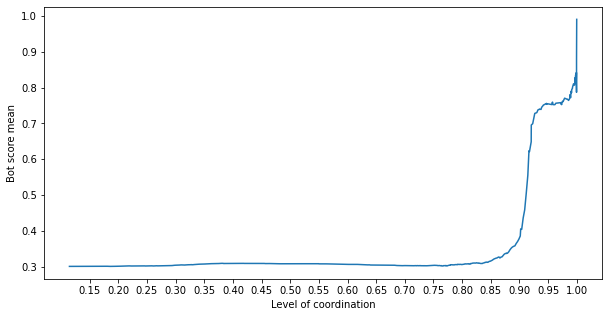

In [69]:
plt.figure(figsize=(10,5))
plt.plot(coordinations, mean_botscores)
plt.xticks([x for x in np.arange(0.15, 1.05, 0.05)])
plt.xlabel("Level of coordination")
plt.ylabel("Bot score mean")